# NivLink Example: Free-Viewing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

/Users/szoro/Documents/software/anaconda3.6/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/szoro/Documents/software/anaconda3.6/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Simulate Data

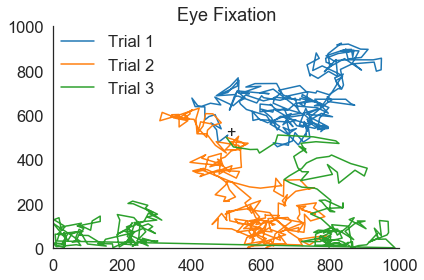

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define metadata.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

xdim = ydim = 1000

n_trials = 3
n_steps = 250

mu = np.array([xdim/2, ydim/2])
drift = 30

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space.
eyepos = np.zeros((n_trials, n_steps, 2))
eyepos[:,0,:] = mu

## Random walk.
for i in np.arange(1,n_steps):
    
    ## Drift.
    eyepos[:,i,:] = eyepos[:,i-1,:] + np.random.normal(0,drift,(n_trials,2))
    
    ## Boundary correct.
    eyepos = np.where(eyepos > xdim, xdim - eyepos, eyepos)
    eyepos = np.where(eyepos < 0, 0 - eyepos, eyepos)
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot eyetracking.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initalize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Plotting.
for i, arr in enumerate(eyepos): ax.plot(*arr.T, label='Trial %s' %(i+1))
ax.set(xlim=(0,xdim),ylim=(0,ydim),title='Eye Fixation')
ax.legend(loc=2, frameon=False, borderpad=0)
ax.text(xdim/2,ydim/2,'+',fontsize=16,zorder=0)

sns.despine()
plt.tight_layout()

## Screen Object

/Users/szoro/Documents/software/anaconda3.6/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


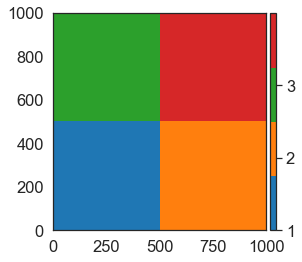

In [3]:
from nivlink import ScreenInfo

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define areas of interest.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize object.
info = ScreenInfo(xdim, ydim, 500)

## Add areas of interest.
info.add_rectangle_aoi(1, 0, xdim/2, 0, ydim/2)
info.add_rectangle_aoi(2, xdim/2, xdim, 0, ydim/2)
info.add_rectangle_aoi(3, 0, xdim/2, ydim/2, ydim)
info.add_rectangle_aoi(4, xdim/2, xdim, ydim/2, ydim)

## Plot areas of interest.
info.plot_aoi(height=4, ticks=True);

## Preprocessing and Results

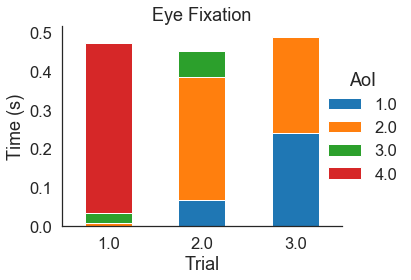

In [4]:
from nivlink import align_to_aoi, compute_fixations

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Align to areas of interest.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

aligned = align_to_aoi(eyepos, info)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute fixations.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

fixations = compute_fixations(aligned, info)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot fixations.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## GroupBy / pivot table.
data = fixations.groupby(['Trial','AoI']).Duration.sum().reset_index()
data = data.pivot('Trial','AoI','Duration')

## Plotting.
ax = data.plot.bar(stacked=True,rot=0)
ax.set(ylabel='Time (s)', title='Eye Fixation')
legend = ax.legend(loc=7,bbox_to_anchor=(1.25,0.5),frameon=False,title='AoI')
legend.get_title().set_fontsize('18')

sns.despine()
plt.tight_layout()